**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

**Load Data**

In [2]:
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")
test_passenger_ids = test_df['PassengerId']

train_df_full = train_df.copy()
test_df_full = test_df.copy()

In [3]:
print(train_df.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**EDA**

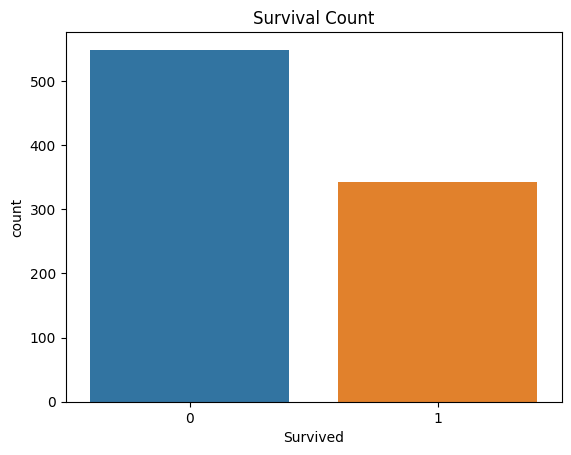

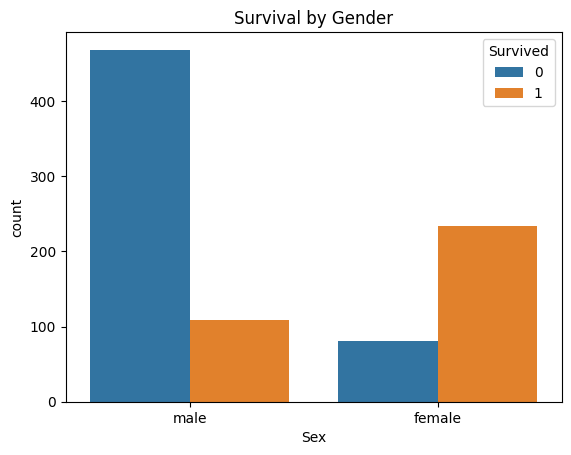

In [6]:
sns.countplot(data=train_df, x='Survived')
plt.title("Survival Count")
plt.show()

sns.countplot(data=train_df, x='Sex', hue='Survived')
plt.title("Survival by Gender")
plt.show()

**Handle Missing Values**

In [7]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age'] = test_df['Age'].fillna(train_df['Age'].median())
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

**Feature Engineering**

In [9]:
for df in [train_df, test_df]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['TicketPrefix'] = df['Ticket'].apply(lambda x: x.replace('.', '').replace('/', '').split()[0] if not x.split()[0].isdigit() else 'None')

**One Hot Encode for Categorical Features**

In [10]:
train_df['TrainFlag'] = 1
test_df['TrainFlag'] = 0
test_df['Survived'] = np.nan

combined_df = pd.concat([train_df, test_df], ignore_index=True)

combined_df = combined_df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1)

categorical_cols = ['Sex', 'Embarked', 'Title', 'TicketPrefix']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols, drop_first=True)

In [11]:
train_df = combined_df[combined_df['TrainFlag'] == 1].drop(['TrainFlag'], axis=1)
test_df = combined_df[combined_df['TrainFlag'] == 0].drop(['TrainFlag', 'Survived'], axis=1)

X = train_df.drop("Survived", axis=1)
y = train_df["Survived"].astype(int)


In [12]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S,...,TicketPrefix_SOPP,TicketPrefix_SOTONO2,TicketPrefix_SOTONOQ,TicketPrefix_SP,TicketPrefix_STONO,TicketPrefix_STONO2,TicketPrefix_STONOQ,TicketPrefix_SWPP,TicketPrefix_WC,TicketPrefix_WEP
0,3,22.0,1,0,7.2500,2,0,True,False,True,...,False,False,False,False,False,False,False,False,False,False
1,1,38.0,1,0,71.2833,2,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,26.0,0,0,7.9250,1,1,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3,1,35.0,1,0,53.1000,2,0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,3,35.0,0,0,8.0500,1,1,True,False,True,...,False,False,False,False,False,False,False,False,False,False


**Feature Scaling**

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_df)

**Train & Evaluate Multiple Models**

**Define Models & Parameter Grids**

In [15]:
models = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), {"C": [0.01, 0.1, 1, 10]}),
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7]}),
    "SVC": (SVC(), {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [3, 5, 7]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [100, 200], "max_depth": [4, 6, 8]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {"n_estimators": [100, 200], "learning_rate": [0.05, 0.1]})
}

**Train Without Tuning**

In [18]:
print("\nTraining without tuning...")
notuned_results = []
best_no_tune_model = None
best_no_tune_score = 0
best_no_tune_name = ""

for name, (model, _) in models.items():
    score = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy').mean()
    notuned_results.append({"Model": name, "Accuracy": round(score, 4)})
    print(f"{name}: {score:.4f}")
    
    if score > best_no_tune_score:
        best_no_tune_score = score
        best_no_tune_model = model
        best_no_tune_name = name



Training without tuning...
Logistic Regression: 0.8171
KNN: 0.8070
SVC: 0.8137
Decision Tree: 0.7868
Random Forest: 0.8047
Gradient Boosting: 0.8249
XGBoost: 0.8249


In [19]:
best_no_tune_model.fit(X_scaled, y)
no_tune_preds = best_no_tune_model.predict(test_scaled)

In [20]:
submission_notuned = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": no_tune_preds.astype(int)
})
submission_notuned.to_csv("submission_notuned.csv", index=False)
print(f"\nSaved: submission_notuned.csv using {best_no_tune_name}")


Saved: submission_notuned.csv using Gradient Boosting


In [21]:
sub_df = pd.read_csv("/kaggle/working/submission_notuned.csv")
sub_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


**Train With Tuning**

In [24]:
tuned_results = []
best_tuned_model = None
best_tuned_score = 0
best_tuned_name = ""

for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_scaled, y)
    tuned_score = grid.best_score_
    tuned_results.append({
        "Model": name,
        "Best Accuracy": round(tuned_score, 4),
        "Best Params": grid.best_params_
    })
    print(f"{name}: {tuned_score:.4f} | Best Params: {grid.best_params_}")

    if tuned_score > best_tuned_score:
        best_tuned_score = tuned_score
        best_tuned_model = grid.best_estimator_
        best_tuned_name = name


Logistic Regression: 0.8193 | Best Params: {'C': 0.1}
KNN: 0.8092 | Best Params: {'n_neighbors': 7}
SVC: 0.8294 | Best Params: {'C': 1, 'kernel': 'linear'}
Decision Tree: 0.8215 | Best Params: {'max_depth': 3}
Random Forest: 0.8283 | Best Params: {'max_depth': 6, 'n_estimators': 200}
Gradient Boosting: 0.8283 | Best Params: {'learning_rate': 0.1, 'n_estimators': 200}
XGBoost: 0.8305 | Best Params: {'learning_rate': 0.05, 'n_estimators': 100}


**Train Final Model & Predict**

In [25]:
best_tuned_model.fit(X_scaled, y)
tuned_preds = best_tuned_model.predict(test_scaled)

In [26]:
submission_tuned = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": tuned_preds.astype(int)
})
submission_tuned.to_csv("submission_tuned.csv", index=False)
print(f"\nSaved: submission_tuned.csv using {best_tuned_name}")


Saved: submission_tuned.csv using XGBoost


In [27]:
sub_df1 = pd.read_csv("/kaggle/working/submission_tuned.csv")
sub_df1.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


**Summary Table**

In [28]:
print("\nAccuracy Comparison:")
df_no = pd.DataFrame(notuned_results).rename(columns={"Accuracy": "No Tuning"})
df_tuned = pd.DataFrame(tuned_results).drop(columns=["Best Params"]).rename(columns={"Best Accuracy": "Tuned"})
comparison = pd.merge(df_no, df_tuned, on="Model")
print(comparison)


Accuracy Comparison:
                 Model  No Tuning   Tuned
0  Logistic Regression     0.8171  0.8193
1                  KNN     0.8070  0.8092
2                  SVC     0.8137  0.8294
3        Decision Tree     0.7868  0.8215
4        Random Forest     0.8047  0.8283
5    Gradient Boosting     0.8249  0.8283
6              XGBoost     0.8249  0.8305
